# **Intro**

 ### Having tried both LDA and NMF, I couldn't clearly distinguish the texts based on the given topics. Since both of these are Unsupervised techniques and our use case was more like a semi supervised one(known labels), I went ahead with the appoach of Guided LDA.

### Guided LDA is a semi-supervised learning algorithm. The idea is to set some seed words for topics that user believes are representative of the underlying topics in the corpus and guide the model to converge around those terms. 

In [ ]:
#Importing the native packages
import pandas as pd
import numpy as np
import re

### Before doing the guidedlda import, There are a few workarounds that needs to be done and this can be implemented only in your local.

### 1)Install lda Library 

### 2)Add the py files from the [workaround here](https://github.com/dex314/GuidedLDA_WorkAround) inside lda folder under site-packages

### This whole process is clearly mentioned in the workaround link.

In [ ]:
#Importing the NLP packages
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from lda import guidedlda

# **Preprocessing**

In [ ]:
def get_wordnet_pos(word):
    '''
    Tags the parts of speech to tokens
    Expects a string and outputs the string with its part of speech
    '''

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)#If its neither of the mentioned POS,returning it as noun

In [ ]:
def word_lemmatizer(text):
    '''
    lemamtizes the tokens based on their part of speech
    Expects a lits of tokens and outputs a list of lemmatized tokens
    '''

    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text, get_wordnet_pos(text))
    return text

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
def reflection_tokenizer(text):
    '''
    Tokenizes a list of string, expects a list of strings and outputs a list of strings.
    before tokenizing:
    1)removes the non-alphanumeric charcaters like emojies
    2)removes the numbers
    3)lower cases the words
    4)tokenizes the sentences
    5)lemmatizes teh tokens
    6)removes the tokens in stop words list
     '''

    text=re.sub(r'[\W_]+', ' ', text) #Just alphnumeric characters
    text=re.sub(r'\d+', '', text) #Removes numbers
    text = text.lower()
    tokens = [word for word in word_tokenize(text)]
    tokens = [word for word in tokens if len(word) >= 3]#removes words smaller than 3 characters
    tokens = [word_lemmatizer(w) for w in tokens]
    tokens = [s for s in tokens if s not in stop_words]
    return tokens

# **Loading Data and Preprocessing**

In [ ]:
df = pd.read_csv(r"Unstructured\Hackathon\data.csv")

In [ ]:
df['lemmatize_token'] = df['text'].apply(reflection_tokenizer)
df['cleaned']=df.apply(lambda x: ' '.join(x['lemmatize_token']),axis=1)

In [ ]:
#Convert a collection of text documents to a matrix of token counts, matrix of documents and tokens
token_vectorizer = CountVectorizer(tokenizer = reflection_tokenizer, min_df=10, stop_words=get_stopwords(), ngram_range=(1, 3))                        

In [ ]:
#function maps the column of the dataframe to a matrix of documents in the rows and token counts as columns,
# this is bag of words representation of the documents
X_ngrams = token_vectorizer.fit_transform(df['cleaned']) 

In [ ]:
#list of terms (words or n_grams of words)
tf_feature_names = token_vectorizer.get_feature_names()

#dictionary of words frequency
word2id = dict((v, idx) for idx, v in enumerate(tf_feature_names))

# **Guided LDA implementation**

### 1)Visualizing the words

### This part becomes necessary because we have to identify the top words and provide these seeds for the distinguishing between topics.

In [ ]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(' '.join(df['cleaned']))
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [ ]:
#Returns the top words
wordcloud.words_

### Now from the top words obtained from the Wordcloud, Identify the tokens that can clearly distinguish between the topics. For eg. 

### 1)The Glassdoor reviews always come with pros, cons, employee etc. which are hardly being used in our other topics 

### 2)Likewise Sports_news talk about the teams, wins, scores and stuff like that

In [ ]:
#keywords for seeded topics that I want GuidedLDA model to converge to 
seed_topic_list_5 = [['pro', 'con', 'company', 'employee','job','pay'],
                   ['feature','price','tech','google','company','brand','technology','mobile'],
                   ['home','house','business traveler','area','stay','solo adventurer'],
                   ['team','game','season','win','point','score','league','club'],
                   ['car','brake','drive','engine','article','vehicle','wheel','subject']]

### NOTE: Make sure you don't provide a lot of seeds for each topics as it might lead to overfitting our model if we were to predict for new test datasets. And also ensure that these seeds are unique to the provided topics.

In [ ]:
#Instantiate the guidedlda as model with parameters like number of topics 
model = guidedlda.GuidedLDA(n_topics=5, n_iter=1000, random_state=7, refresh=10,alpha=0.01,eta=0.01)
#seed_topics is the dictionary {word_id to topic_id}
seed_topics = {}
for t_id, st in enumerate(seed_topic_list_5):
    for word in st:
        seed_topics[word2id[word]] = t_id

#build the model on the dataset with 5 topics
#tseed_confidence: how much extra boost should be given to a term between 0 to 1
model.fit(X_ngrams, seed_topics=seed_topics, seed_confidence=0.3)

In [ ]:
#Displaying the top 15 words from each topic after fitting our model
n_top_words = 15
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(tf_feature_names)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

In [ ]:
#Creating a dataframe of topics
doc_topic = model.transform(X_ngrams)
columns_label = [i for i in range(5)]  # number of topics
topic_vector = pd.DataFrame(doc_topic, columns = columns_label)#dataframe of doc-topics
final=topic_vector.round(2)

### This provides a dataframe containing the probabilities for each document corresponding to the topics
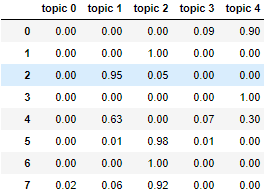

In [ ]:
#Extracting the topics with most probability for each document
final_data=final.eq(final.max(1), axis=0).dot(final.columns)

In [ ]:
#Modifying the output based on submission format
output=pd.DataFrame()
output['Id']=df['Id'].values
output['topic']=final_data.values
output.replace({"0": 'glassdoor_reviews','1':'tech_news','2':'room_rentals','3':'sports_news','4':'Automobiles'},inplace=True)

In [ ]:
output.to_csv('Hackathon_submission.csv',index=False)